# System call Anomaly Detection- Deep Learning 

**ADFA Dataset Preprocessing:**

    1. The system call language model estimates the probability distribution of the next call in a sequence given the sequence of previous calls. 
       
    2. We assume that the host system generates a finite number of system calls. 
    
    3. We index each system call by using an integer starting from 1 and denote the fixed set of all possible system calls in the system as S = {1, · · · , K}. Let x = x1x2 · · · xl(xi ∈ S) denote a sequence of l system calls.
       
**LSTM Based Model :**     

    1. At the Input Layer, the call at each time step xi is fed into the model in the form of one-hot encoding,
       in other words, a K dimensional vector with all elements zero except position xi.
       
    2. At the Embedding Layer*, incoming calls are embedded to continuous space by multiplying embedding matrix W,
       which should be learned. 
       
    3. At the Hidden Layer*, the LSTM unit has an internal state, and this state is updated recurrently at each time step.
    
    4. At the Output Layer, a softmax activation function is used to produce the estimation of normalized probability values of possible calls coming next in the sequence.
    
**References for systemcalls:**
    1. http://osinside.net/syscall/system_call_table.htm
    2. https://www.cs.unm.edu/~immsec/systemcalls.htm    
    3. https://github.com/karpathy/char-rnn
    4. https://keras.io/losses/#categorical_crossentropy
    5. http://karpathy.github.io/2015/05/21/rnn-effectiveness/

# ADFA Dataset Preprocessing

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Aug  1 13:52:35 2019

@author: kuna
"""

#!/usr/bin/env python
# -*- coding: utf-8 -*-


import pickle
import sys

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
# ignore all user warnings
simplefilter(action='ignore', category=UserWarning)

def saveintopickle(obj, filename):
    with open(filename, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

    print ("[Pickle]: save object into {}".format(filename))
    return



def loadfrompickle(filename):
    with open(filename, 'rb') as handle:
        b = pickle.load(handle)
    return b



#draw the  process bar
def drawProgressBar(percent, barLen = 20):
    sys.stdout.write("\r")
    progress = ""
    for i in range(barLen):
        if i < int(barLen * percent):
            progress += "="
        else:
            progress += " "
    sys.stdout.write("[ %s ] %.2f%%" % (progress, percent * 100))
    sys.stdout.flush()

In [2]:
import numpy as np
#import io_helper


random_data_dup = 10  # each sample randomly duplicated between 0 and 9 times, see dropin function


def dropin(X, y):
    """
    The name suggests the inverse of dropout, i.e. adding more samples. See Data Augmentation section at
    http://simaaron.github.io/Estimating-rainfall-from-weather-radar-readings-using-recurrent-neural-networks/
    :param X: Each row is a training sequence
    :param y: Tne target we train and will later predict
    :return: new augmented X, y
    """
    print("X shape:", X.shape)
    print("y shape:", y.shape)
    X_hat = []
    y_hat = []
    for i in range(0, len(X)):
        for j in range(0, np.random.random_integers(0, random_data_dup)):
            X_hat.append(X[i, :])
            y_hat.append(y[i])
    return np.asarray(X_hat), np.asarray(y_hat)



def preprocess():

    arrayfile = "./array_test.pickle"
    array = loadfrompickle(arrayfile)
    #print(type(array))
    #print(array)
    x_train = array[:,:-1]
    y_train = array[:,-1]

    print ("The train data size is that ")
    print (x_train.shape)
    print (y_train.shape)
    return (x_train,y_train)

def preprocess_val():

    arrayfile = "./array_val.pickle"
    array = loadfrompickle(arrayfile)
    #print(type(array))
    #print(array)
    x_test = array[:,:-1]
    y_test = array[:,-1]

    print ("The train data size is that ")
    print (x_test.shape)
    print (y_test.shape)
    return (x_test,y_test)

#if __name__ =="__main__":
#   preprocess()

In [3]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


import os
import sys
import numpy as np

#import io_helper

def readfilesfromAdir(dataset):
    #read a list of files
    files = os.listdir(dataset)
    files_absolute_paths = []
    for i in files:
        files_absolute_paths.append(dataset+str(i))
    return files_absolute_paths


file = "ADFA-LD/Training_Data_Master/UTD-0001.txt"
#this is used to read a char sequence from
def readCharsFromFile(file):
    channel_values = open(file).read().split()
    #print (len(channel_values))
    #channel_values is a list
    return channel_values
    #print (channel_values[800:819])

def get_attack_subdir(path):
    subdirectories = os.listdir(path)
    for i in range(0,len(subdirectories)):
        subdirectories[i] = path + subdirectories[i]

    print (subdirectories)
    return (subdirectories)


def get_all_call_sequences(dire):
    files = readfilesfromAdir(dire)
    allthelist = []
    print (len(files))

    for eachfile in files:
        if not eachfile.endswith("DS_Store"):
            allthelist.append(readCharsFromFile(eachfile))
        else:
            print ("Skip the file "+ str(eachfile))

    elements = []
    for item in allthelist:
        for key in item:
            if key not in elements:
                elements.append(key)

    elements = map(int,elements)
    elements = sorted(elements)

    print ("The total unique elements:")
    print (elements)

    print ("The maximum number of elements:")
    print (max(elements))

    #print ("The length elements:")
    #print (len(elements))
    print (len(allthelist))

    #clean the all list data set
    _max = 0
    for i in range(0,len(allthelist)):
        _max = max(_max,len(allthelist[i]))
        allthelist[i] = list(map(int,allthelist[i]))
        #print(allthelist[i])


    print ("The maximum length of a sequence is that {}".format(_max))

    return (allthelist)

## shift the data for analysis
def shift(seq, n):
    n = n % len(seq)
    return seq[n:] + seq[:n]


def convertToOneHot(vector, num_classes=None):
    """
    Converts an input 1-D vector of integers into an output
    2-D array of one-hot vectors, where an i'th input value
    of j will set a '1' in the i'th row, j'th column of the
    output array.

    Example:
        v = np.array((1, 0, 4))
        one_hot_v = convertToOneHot(v)
        print one_hot_v

        [[0 1 0 0 0]
         [1 0 0 0 0]
         [0 0 0 0 1]]
    """

    assert isinstance(vector, np.ndarray)
    assert len(vector) > 0

    if num_classes is None:
        num_classes = np.max(vector)+1
    else:
        assert num_classes > 0
        assert num_classes >= np.max(vector)

    result = np.zeros(shape=(len(vector), num_classes))
    result[np.arange(len(vector)), vector] = 1
    return result.astype(int)

"""
The num_class here is set as 341
"""

#one function do one thing
def sequence_n_gram_parsing(alist,n_gram=20,num_class=341):
    if len(alist) <= n_gram:
        return alist

    ans = []
    for i in range(0,len(alist)-n_gram+1,1):
        tmp = alist[i:i+n_gram]
        oneHot = convertToOneHot(np.asarray(tmp), num_class)
        #print(tmp)
        #print(np.asarray(tmp))
        #print(oneHot)
        ans.append(oneHot)

    #transform into nmup arrray
    ans = np.array(ans)
    return (ans)


def lists_of_list_into_big_matrix(allthelist,n_gram=20):
    
    print("lists_of_list_into_big_matrix")
    print(len(allthelist))
    array = sequence_n_gram_parsing(allthelist[0])
    #print(len(allthelist[0]))
    #print(allthelist[0])
    #print(len(array))
    #print(array)

    for i in range(1,len(allthelist),1):
       
        tmp = sequence_n_gram_parsing(allthelist[i])
       
        #print ("tmp shape")
        #print(tmp)
        #print (len(tmp))
 
        array = np.concatenate((array, tmp), axis=0)
        #print(allthelist[i])
        #print(array)

        percent = (i+0.0)/len(allthelist)
        #io_helper.drawProgressBar(percent)
        drawProgressBar(percent)

        if (len(array)> 20000):
            break
        #print ("array shape")
        #print (array.shape)
        #print(len(allthelist[1]))
        #print(allthelist[1])
        #print(len(array))
        #print(array)
        #break

    print (array.shape)
    print ("done")
    #io_helper.saveintopickle(array,"array_test.pickle")
    saveintopickle(array,"array_test.pickle")


def lists_of_list_into_big_matrix_val(allthelist,n_gram=20):

    array = sequence_n_gram_parsing(allthelist[0])

    for i in range(1,len(allthelist),1):
        tmp = sequence_n_gram_parsing(allthelist[i])

       # print ("tmp shape")
       # print (tmp.shape)

        array = np.concatenate((array, tmp), axis=0)


        percent = (i+0.0)/len(allthelist)
        #io_helper.drawProgressBar(percent)
        drawProgressBar(percent)

        if (len(array)> 20000):
            break
        #print ("array shape")
        #print (array.shape)
       

    print (array.shape)
    print ("done")
    #io_helper.saveintopickle(array,"array_test.pickle")
    saveintopickle(array,"array_val.pickle")


if __name__ == "__main__":
    dirc = "ADFA-LD/Training_Data_Master/"
    dirc_val = "ADFA-LD/Validation_Data_Master/"
    dic_attack ="ADFA-LD/Attack_Data_Master/Adduser_1/"
    #train1 = get_all_call_sequences(dirc)

    #test = [i for i in range(0,300)]
    #array = sequence_n_gram_parsing(test)
    #print (type(array))
    #print (array.shape)

    #get_attack_subdir(dic_attack)
    #print ("XxxxxxxXXXXXXXXXXX")
    #val1 = get_all_call_sequences(dirc_val)
    
    #dirc_test = "Test/"
    #att_test = get_all_call_sequences(dirc_test)
    #lists_of_list_into_big_matrix(att_test)
    
    att = get_all_call_sequences(dirc)
    lists_of_list_into_big_matrix(att)
    
    att_val = get_all_call_sequences(dirc_val)
    lists_of_list_into_big_matrix_val(att_val)


834
Skip the file ADFA-LD/Training_Data_Master/.DS_Store
The total unique elements:
[1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 19, 20, 21, 26, 27, 30, 33, 37, 38, 39, 40, 41, 42, 43, 45, 54, 57, 60, 63, 64, 65, 66, 75, 77, 78, 83, 85, 91, 93, 94, 96, 97, 99, 102, 104, 110, 114, 117, 118, 119, 120, 122, 125, 128, 132, 133, 140, 141, 142, 143, 144, 146, 148, 155, 157, 158, 159, 160, 162, 163, 168, 172, 174, 175, 176, 179, 180, 183, 184, 185, 191, 192, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 211, 212, 213, 214, 219, 220, 221, 224, 226, 228, 229, 230, 231, 233, 234, 240, 242, 243, 252, 254, 255, 256, 258, 259, 260, 264, 265, 266, 268, 269, 270, 272, 289, 292, 293, 295, 298, 300, 301, 307, 308, 309, 311, 314, 320, 322, 331, 332, 340]
The maximum number of elements:
340
833
The maximum length of a sequence is that 2948
lists_of_list_into_big_matrix
833
[ =                    ] 8.52%(20298, 20, 341)
done
[Pickle]: save object into array_test.pickle
43

# LSTM Based Model

In [4]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import matplotlib.pyplot as plt
import numpy as np
import time
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers.embeddings import Embedding

#import preprocess

# Global hyper-parameters
sequence_length = 19
epochs = 1
batch_size = 50
feature_dimension = 341
top_words = 5000

def save_model_weight_into_file(model, modelname="model.json", weight="model.h5"):
    model_json = model.to_json()
    with open(modelname, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(weight)
    print("Saved model to disk in {} and {}".format(modelname,weight))


def load_model_and_wieght_from_file(modelname="model.json", weight="model.h5"):

    json_file = open(modelname, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(weight)
    print("Loaded model from disk, you can do more analysis more")

    pass


def build_model():
    model = Sequential()
    layers = {'input': feature_dimension, 'hidden1': 64, 'hidden2': 256, 'hidden3': 100, 'output': feature_dimension}

    model.add(LSTM(
            input_length=sequence_length,
            input_dim=layers['input'],
            output_dim=layers['hidden1'],
            return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
            layers['hidden2'],
            return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
            layers['hidden3'],
            return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
            output_dim=layers['output'],activation='softmax'))
    #model.add(Activation("linear"))

    start = time.time()

    model.compile(loss="categorical_crossentropy", optimizer='rmsprop',  metrics=['accuracy'])
    #model.compile(loss="mse", optimizer="rmsprop")

    #print ("Compilation Time : "%(time.time() - start))
    return model

from keras.callbacks import EarlyStopping

def run_network(model=None, data=None):

    global_start_time = time.time()
    
    if data is None:
        print ('Loading data... ')
        # train on first 700 samples and test on next 300 samples (has anomaly)
        X_train, y_train  = preprocess()
    else:
        X_train, y_train = data

    print ("X_train, y_train,shape")
    print (X_train.shape)
    print (y_train.shape)
    print ('\nData Loaded. Compiling...\n')

    if model is None:
        model = build_model()
        #model = build_model_2()
        print("Training...")
        model.fit(
                X_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_split=0.3)
        model.summary()
        print("Done Training...")

    #predicted = model.predict(X_test)
    #print("Reshaping predicted")
    #predicted = np.reshape(predicted, (predicted.size,))



   
    """
    except KeyboardInterrupt:
        print("prediction exception")
        print 'Training duration (s) : ', time.time() - global_start_time
        return model, y_test, 0
   
    try:
        plt.figure(1)
        plt.subplot(311)
        plt.title("Actual Test Signal w/Anomalies")
        plt.plot(y_test[:len(y_test)], 'b')
        plt.subplot(312)
        plt.title("Predicted Signal")
        plt.plot(predicted[:len(y_test)], 'g')
        plt.subplot(313)
        plt.title("Squared Error")
        mse = ((y_test - predicted) ** 2)
        plt.plot(mse, 'r')
        plt.show()
    except Exception as e:
        print("plotting exception")
        print (str(e))
    print ('Training duration (s) : '% (time.time() - global_start_time))

    return model, y_test, predicted
   """

#if __name__ == "__main__":
# run_network()    

Using TensorFlow backend.


## Train LSTM Model

In [5]:
global_start_time = time.time()
    
model=None

print ('Loading data... ')
# train on first 700 samples and test on next 300 samples (has anomaly)
X_train, y_train  = preprocess()

print ("X_train, y_train,shape")
print (X_train.shape)
print (y_train.shape)
print ('\nData Loaded. Compiling...\n')

if model is None:
    model = build_model()
    print("Training...")
    history = model.fit(
            X_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=0.3,
            callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
    model.summary()
    print("Done Training...")


Loading data... 
The train data size is that 
(20298, 19, 341)
(20298, 341)
X_train, y_train,shape
(20298, 19, 341)
(20298, 341)

Data Loaded. Compiling...

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Training...
Instructions for updating:
Use tf.cast instead.
Train on 14208 samples, validate on 6090 samples
Epoch 1/1
14208/14208 [==============================] - 32s 2ms/step - loss: 2.7770 - acc: 0.2367 - val_loss: 2.8779 - val_acc: 0.2154
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 19, 64)            103936    
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)  

In [6]:
#import pandas as pd

#def loadData(file): 
    # for reading also binary mode is important 
#    dbfile = open(file, 'rb')      
#    db = pickle.load(dbfile) 
#    for keys in db: 
#        print(keys, '=>', db[keys]) 
#    dbfile.close() 
  
#if __name__ == '__main__': 
#    loadData("./array_test.pickle") 
#df_val = pd.read_pickle("./array_val.pickle")
#df_val.head()

## Run model on Validation Data

In [7]:
# https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

X_test, y_test = preprocess_val()

print ("X_test, y_test,shape")
print (X_test.shape)
print (y_test.shape)

print("Validating...")
predicted = model.predict(X_test)
print("Done Validating...")
print(predicted)


The train data size is that 
(21238, 19, 341)
(21238, 341)
X_test, y_test,shape
(21238, 19, 341)
(21238, 341)
Validating...
Done Validating...
[[2.8147128e-05 3.8867351e-02 5.9301241e-05 ... 3.2527638e-05
  4.0639268e-05 6.0572522e-04]
 [2.7337572e-05 4.2425249e-02 5.7118334e-05 ... 3.0709063e-05
  3.9311104e-05 5.8961258e-04]
 [3.2080068e-05 4.1573644e-02 6.1957377e-05 ... 3.6363443e-05
  4.3218708e-05 6.0780835e-04]
 ...
 [1.8595829e-06 1.2511486e-03 3.5294606e-06 ... 2.1812916e-06
  1.6237399e-06 6.7461682e-05]
 [1.8240867e-06 1.3079355e-03 3.5116327e-06 ... 2.1674750e-06
  1.6114174e-06 6.7553679e-05]
 [1.8013474e-06 1.3025296e-03 3.4824586e-06 ... 2.1350809e-06
  1.6007832e-06 6.6800356e-05]]


## How did our model perform?

In [8]:

score, accuracy = model.evaluate(X_test, y_test, verbose=2, batch_size=batch_size)
print('Score : %.2f'%(score))
print('Validation Accuracy : %.2f'%(accuracy))

Score : 3.08
Validation Accuracy : 0.19


In [9]:
#plt.title('Loss')
#plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='test')
#plt.legend()
#plt.show();

In [10]:
history.history

{'val_loss': [2.8778519998434535],
 'val_acc': [0.21543513882556573],
 'loss': [2.776978516363883],
 'acc': [0.23669763501452468]}

In [11]:
#plt.title('Accuracy')
#plt.plot(history.history['acc'], label='train')
#plt.plot(history.history['val_acc'], label='test')
#plt.legend()
#plt.show();

## How to Test with new systemcall  sequence ??

## Train LSTM simpler model

In [12]:
# https://towardsdatascience.com/choosing-the-right-hyperparameters-for-a-simple-lstm-using-keras-f8e9ed76f046

word_vec_length = 19
char_vec_length = 341
output_labels = 341


#hidden_nodes = 4000 # int(2/3 * (word_vec_length * char_vec_length))
hidden_nodes = 100
print(f"The number of hidden nodes is {hidden_nodes}.")

def build_model_2():
    # Build the model
    print('Build model...')
    model = Sequential()
    model.add(LSTM(hidden_nodes, return_sequences=False, input_shape=(word_vec_length, char_vec_length)))
    model.add(Dropout(0.2))
    model.add(Dense(units=output_labels))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    #print ("Compilation Time : "%(time.time() - start))
    return model

The number of hidden nodes is 100.


In [13]:
global_start_time = time.time()
    
model=None

print ('Loading data... ')
# train on first 700 samples and test on next 300 samples (has anomaly)
X_train, y_train  = preprocess()

print ("X_train, y_train,shape")
print (X_train.shape)
print (y_train.shape)
print ('\nData Loaded. Compiling...\n')

batch_size=32
model = build_model_2()
print("Training...")
model.fit(X_train, y_train, batch_size=batch_size, epochs=10, validation_data=(X_test, y_test))
model.summary()
print("Done Training...")


Loading data... 
The train data size is that 
(20298, 19, 341)
(20298, 341)
X_train, y_train,shape
(20298, 19, 341)
(20298, 341)

Data Loaded. Compiling...

Build model...
Training...
Train on 20298 samples, validate on 21238 samples
Epoch 1/10
20298/20298 [==============================] - 22s 1ms/step - loss: 2.8397 - acc: 0.2396 - val_loss: 2.5586 - val_acc: 0.4236
Epoch 2/10
20298/20298 [==============================] - 21s 1ms/step - loss: 1.9795 - acc: 0.4184 - val_loss: 2.1248 - val_acc: 0.4901
Epoch 3/10
20298/20298 [==============================] - 21s 1ms/step - loss: 1.6778 - acc: 0.5024 - val_loss: 2.0376 - val_acc: 0.5023
Epoch 4/10
20298/20298 [==============================] - 21s 1ms/step - loss: 1.5040 - acc: 0.5570 - val_loss: 1.9283 - val_acc: 0.5027
Epoch 5/10
20298/20298 [==============================] - 20s 977us/step - loss: 1.3988 - acc: 0.5863 - val_loss: 1.9624 - val_acc: 0.5107
Epoch 6/10
20298/20298 [==============================] - 20s 1ms/step - loss: 

In [14]:
score, accuracy = model.evaluate(X_train, y_train, verbose=2, batch_size=batch_size)
print('Train Score : %.2f'%(score))
print('Train Validation Accuracy : %.2f'%(accuracy))

Train Score : 1.05
Train Validation Accuracy : 0.68


In [15]:
score, accuracy = model.evaluate(X_test, y_test, verbose=2, batch_size=batch_size)
print('Test Score : %.2f'%(score))
print('Test Validation Accuracy : %.2f'%(accuracy))

Test Score : 2.03
Test Validation Accuracy : 0.52


In [16]:
## k-fold validation
from sklearn.model_selection import StratifiedKFold
import numpy

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# split into input (X) and output (Y) variables
X = X_train
Y = y_train
Y

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [17]:
# define 10-fold cross validation test harness
#kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
#cvscores = []
#for train, test in kfold.split(X, Y):
#  # create model
#	model = Sequential()
#	model.add(Dense(12, input_dim=341, activation='relu'))
#	model.add(Dense(8, activation='relu'))
#	model.add(Dense(1, activation='sigmoid'))
#	# Compile model
#	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#	# Fit the model
#	model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
#	# evaluate the model
#	scores = model.evaluate(X[test], Y[test], verbose=0)
#	print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
#	cvscores.append(scores[1] * 100)
#print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

In [18]:
# https://towardsdatascience.com/choosing-the-right-hyperparameters-for-a-simple-lstm-using-keras-f8e9ed76f046

word_vec_length = 19
char_vec_length = 341
output_labels = 341


hidden_nodes = 100 # int(2/3 * (word_vec_length * char_vec_length))
print(f"The number of hidden nodes is {hidden_nodes}.")

def build_model_3():
    # Build the model
    print('Build model...')
    model = Sequential()
    model.add(LSTM(hidden_nodes, return_sequences=False, input_shape=(word_vec_length, char_vec_length)))
    model.add(Dropout(0.5))
    model.add(Dense(units=output_labels))
    model.add(Activation('softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    #print ("Compilation Time : "%(time.time() - start))
    return model

global_start_time = time.time()
    
model=None

print ('Loading data... ')
# train on first 700 samples and test on next 300 samples (has anomaly)
X_train, y_train  = preprocess()

print ("X_train, y_train,shape")
print (X_train.shape)
print (y_train.shape)
print ('\nData Loaded. Compiling...\n')

batch_size=32
model = build_model_3()
print("Training...")
model.fit(X_train, y_train, batch_size=batch_size, epochs=10, validation_data=(X_test, y_test))
model.summary()
print("Done Training...")

The number of hidden nodes is 100.
Loading data... 
The train data size is that 
(20298, 19, 341)
(20298, 341)
X_train, y_train,shape
(20298, 19, 341)
(20298, 341)

Data Loaded. Compiling...

Build model...
Training...
Train on 20298 samples, validate on 21238 samples
Epoch 1/10
20298/20298 [==============================] - 24s 1ms/step - loss: 0.0118 - acc: 0.9971 - val_loss: 0.0100 - val_acc: 0.9973
Epoch 2/10
20298/20298 [==============================] - 20s 1ms/step - loss: 0.0086 - acc: 0.9973 - val_loss: 0.0086 - val_acc: 0.9976 0.99 - ETA: 5s - loss: 0. - ETA: 4s - loss: 0.00 - ETA: 3s - loss: 0.0087 - acc: 0.9 - ETA: 3s - loss: 0.0087 - - ETA: 2s - loss: 0. - ETA: 1s - loss: 0.
Epoch 3/10
20298/20298 [==============================] - 23s 1ms/step - loss: 0.0076 - acc: 0.9975 - val_loss: 0.0083 - val_acc: 0.9977
Epoch 4/10
20298/20298 [==============================] - 24s 1ms/step - loss: 0.0070 - acc: 0.9977 - val_loss: 0.0080 - val_acc: 0.9978
Epoch 5/10
20298/20298 [=====

In [19]:
def build_model_4():
    # Build the model
    print('Build model...')
    model = Sequential()
    model.add(LSTM(hidden_nodes, return_sequences=False, input_shape=(word_vec_length, char_vec_length)))
    model.add(Dropout(0.2))
    model.add(Dense(units=output_labels))
    model.add(Activation('softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    #print ("Compilation Time : "%(time.time() - start))
    return model

global_start_time = time.time()
    
model=None

print ('Loading data... ')
# train on first 700 samples and test on next 300 samples (has anomaly)
X_train, y_train  = preprocess()

print ("X_train, y_train,shape")
print (X_train.shape)
print (y_train.shape)
print ('\nData Loaded. Compiling...\n')

batch_size=32
model = build_model_4()
print("Training...")
model.fit(X_train, y_train, batch_size=batch_size, epochs=10, validation_data=(X_test, y_test))
model.summary()
print("Done Training...")

Loading data... 
The train data size is that 
(20298, 19, 341)
(20298, 341)
X_train, y_train,shape
(20298, 19, 341)
(20298, 341)

Data Loaded. Compiling...

Build model...
Training...
Train on 20298 samples, validate on 21238 samples
Epoch 1/10
20298/20298 [==============================] - 23s 1ms/step - loss: 0.0112 - acc: 0.9971 - val_loss: 0.0099 - val_acc: 0.9975
Epoch 2/10
20298/20298 [==============================] - 20s 986us/step - loss: 0.0082 - acc: 0.9974 - val_loss: 0.0085 - val_acc: 0.9977
Epoch 3/10
20298/20298 [==============================] - 20s 996us/step - loss: 0.0071 - acc: 0.9976 - val_loss: 0.0080 - val_acc: 0.9978
Epoch 4/10
20298/20298 [==============================] - 21s 1ms/step - loss: 0.0065 - acc: 0.9978 - val_loss: 0.0078 - val_acc: 0.9978
Epoch 5/10
20298/20298 [==============================] - 22s 1ms/step - loss: 0.0061 - acc: 0.9979 - val_loss: 0.0078 - val_acc: 0.9978
Epoch 6/10
20298/20298 [==============================] - 22s 1ms/step - loss

In [20]:
def build_model_5():
    # Build the model
    print('Build model...')
    model = Sequential()
    model.add(LSTM(hidden_nodes, return_sequences=False, input_shape=(word_vec_length, char_vec_length)))
    #model.add(Dropout(0.2))
    model.add(Dense(units=output_labels))
    model.add(Activation('softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    #print ("Compilation Time : "%(time.time() - start))
    return model

global_start_time = time.time()
    
model=None

print ('Loading data... ')
# train on first 700 samples and test on next 300 samples (has anomaly)
X_train, y_train  = preprocess()

print ("X_train, y_train,shape")
print (X_train.shape)
print (y_train.shape)
print ('\nData Loaded. Compiling...\n')

batch_size=32
model = build_model_5()
print("Training...")
model.fit(X_train, y_train, batch_size=batch_size, epochs=10, validation_data=(X_test, y_test))
model.summary()
print("Done Training...")

Loading data... 
The train data size is that 
(20298, 19, 341)
(20298, 341)
X_train, y_train,shape
(20298, 19, 341)
(20298, 341)

Data Loaded. Compiling...

Build model...
Training...
Train on 20298 samples, validate on 21238 samples
Epoch 1/10
20298/20298 [==============================] - 28s 1ms/step - loss: 0.0111 - acc: 0.9971 - val_loss: 0.0100 - val_acc: 0.9973
Epoch 2/10
20298/20298 [==============================] - 21s 1ms/step - loss: 0.0080 - acc: 0.9974 - val_loss: 0.0085 - val_acc: 0.9977
Epoch 3/10
20298/20298 [==============================] - 22s 1ms/step - loss: 0.0069 - acc: 0.9977 - val_loss: 0.0081 - val_acc: 0.9978
Epoch 4/10
20298/20298 [==============================] - 21s 1ms/step - loss: 0.0062 - acc: 0.9979 - val_loss: 0.0080 - val_acc: 0.9978
Epoch 5/10
20298/20298 [==============================] - 21s 1ms/step - loss: 0.0059 - acc: 0.9980 - val_loss: 0.0079 - val_acc: 0.9978
Epoch 6/10
20298/20298 [==============================] - 22s 1ms/step - loss: 0.

In [21]:
score, accuracy = model.evaluate(X_train, y_train, verbose=2, batch_size=batch_size)
print('Train Score : %.2f'%(score))
print('Train Validation Accuracy : %.2f'%(accuracy))

Train Score : 0.00
Train Validation Accuracy : 1.00


In [22]:
score, accuracy = model.evaluate(X_test, y_test, verbose=2, batch_size=batch_size)
print('Test Score : %.2f'%(score))
print('Test Validation Accuracy : %.2f'%(accuracy))

Test Score : 0.01
Test Validation Accuracy : 1.00


## LSTM for Binary Classification of SystemCalls

In [244]:
def preprocess():

    arrayfile = "./array_test.pickle"
    array = loadfrompickle(arrayfile)
    #print(type(array))
    #print(array)
    x_train = array[:,:]
    print (x_train.shape)
    x_train = x_train.reshape(40099, 20, 1)
    y_train = np.zeros((40099,1))

    print ("The train data size is that ")
    print (x_train.shape)
    print (y_train.shape)
    return (x_train,y_train)

def preprocess_val():

    arrayfile = "./array_val.pickle"
    array = loadfrompickle(arrayfile)
    #print(type(array))
    #print(array)
    x_test = array[:,:]
    print (x_test.shape)
    x_test = x_test.reshape(40142, 20, 1)
    y_test = np.zeros((40142,1))

    print ("The validation data size is that ")
    print (x_test.shape)
    print (y_test.shape)
    return (x_test,y_test)

def preprocess_attack():

    arrayfile = "./array_attack.pickle"
    array = loadfrompickle(arrayfile)
    #print(type(array))
    #print(array)
    x_attack = array[:,:]
    x_attack = x_attack.reshape(6184, 20, 1)
    y_attack = np.ones((6184,1))

    print ("The attack data size is that ")
    print (x_attack.shape)
    print (y_attack.shape)
    return (x_attack,y_attack)


"""
The num_class here is set as 1
"""

#one function do one thing
def sequence_n_gram_parsing_noencoding(alist,n_gram=20,num_class=1):
    if len(alist) <= n_gram:
        return alist

    ans = []
    for i in range(0,len(alist)-n_gram+1,1):
        tmp = alist[i:i+n_gram]
        #oneHot = convertToOneHot(np.asarray(tmp), num_class)
        #print(tmp)
        #print(np.asarray(tmp))
        #print(oneHot)
        ans.append(tmp)

    #transform into nmup arrray
    ans = np.array(ans)
    return (ans)


def lists_of_list_into_big_matrix(allthelist,n_gram=20):
    
    #print("lists_of_list_into_big_matrix train")
    #print(len(allthelist))
    array = sequence_n_gram_parsing_noencoding(allthelist[0])
    #print(len(allthelist[0]))
    #print(allthelist[0])
    #print(len(array))
    #print(array)

    for i in range(1,len(allthelist),1):
       
        tmp = sequence_n_gram_parsing_noencoding(allthelist[i])
       
        #print ("tmp shape")
        #print(tmp.shape)
        #print(array.shape)
        #print (len(tmp))
 
        array = np.concatenate((array, tmp), axis=0)
        #print(allthelist[i])
        #print(array)

        percent = (i+0.0)/len(allthelist)
        #io_helper.drawProgressBar(percent)
        drawProgressBar(percent)

        if (len(array)> 40000):
            break
        #print ("array shape")
        #print (array.shape)
        #print(len(allthelist[1]))
        #print(allthelist[1])
        #print(len(array))
        #print(array)
        #break

    print (array.shape)
    print ("done")
    #io_helper.saveintopickle(array,"array_test.pickle")
    saveintopickle(array,"array_test.pickle")


def lists_of_list_into_big_matrix_val(allthelist,n_gram=20):

    #print("lists_of_list_into_big_matrix validation")
    #print(len(allthelist))
    array = sequence_n_gram_parsing_noencoding(allthelist[0])
    #print(len(allthelist[0]))
    #print(allthelist[0])
    #print(len(array))
    #print(array)

    for i in range(1,len(allthelist),1):
        tmp = sequence_n_gram_parsing_noencoding(allthelist[i])

       # print ("tmp shape")
       # print (tmp.shape)

        array = np.concatenate((array, tmp), axis=0)


        percent = (i+0.0)/len(allthelist)
        #io_helper.drawProgressBar(percent)
        drawProgressBar(percent)

        if (len(array)> 40000):
            break
        #print ("array shape")
        #print (array.shape)
       

    print (array.shape)
    print ("done")
    #io_helper.saveintopickle(array,"array_test.pickle")
    saveintopickle(array,"array_val.pickle")

def get_all_call_sequences_attack(dire):
    # list of attacks
    attack = ['Adduser','Hydra_FTP','Hydra_SSH','Java_Meterpreter','Meterpreter','Web_Shell']
    #attack = ['Adduser' ,'Hydra_FTP']
    for term in attack:
        in_address = dire+term          
        for i in range (1,11):
            files = readfilesfromAdir(in_address+"_"+str(i)+"/")
        
    allthelist = []
    #print(files)
    #print (len(files))

    for eachfile in files:
        if not eachfile.endswith("DS_Store"):
            allthelist.append(readCharsFromFile(eachfile))
        else:
            print ("Skip the file "+ str(eachfile))

    elements = []
    for item in allthelist:
        for key in item:
            if key not in elements:
                elements.append(key)

    elements = map(int,elements)
    elements = sorted(elements)

    print ("The total unique elements:")
    print (elements)

    print ("The maximum number of elements:")
    print (max(elements))

    #print ("The length elements:")
    #print (len(elements))
    print (len(allthelist))

    #clean the all list data set
    _max = 0
    for i in range(0,len(allthelist)):
        _max = max(_max,len(allthelist[i]))
        allthelist[i] = list(map(int,allthelist[i]))
        #print(allthelist[i])


    print ("The maximum length of a sequence is that {}".format(_max))

    return (allthelist)

def lists_of_list_into_big_matrix_attack(allthelist,n_gram=20):

    array = sequence_n_gram_parsing_noencoding(allthelist[0])

    for i in range(1,len(allthelist),1):
        tmp = sequence_n_gram_parsing_noencoding(allthelist[i])

       # print ("tmp shape")
        #print (tmp.shape)
        #print (array.shape)

        array = np.concatenate((array, tmp), axis=0)


        percent = (i+0.0)/len(allthelist)
        #io_helper.drawProgressBar(percent)
        drawProgressBar(percent)

        if (len(array)> 40000):
            break
        #print ("array shape")
        #print (array.shape)
       

    print (array.shape)
    print ("done")
    #io_helper.saveintopickle(array,"array_test.pickle")
    saveintopickle(array,"array_attack.pickle")
    #pickle2csv("array_attack.pickle", "attack.csv")


            
    
if __name__ == "__main__":
    dirc = "ADFA-LD/Training_Data_Master/"
    dirc_val = "ADFA-LD/Validation_Data_Master/"
    dic_attack ="ADFA-LD/Attack_Data_Master/"
    
    att = get_all_call_sequences(dirc)
    lists_of_list_into_big_matrix(att)
    
    att_val = get_all_call_sequences(dirc_val)
    lists_of_list_into_big_matrix_val(att_val)
    
    att_attack = get_all_call_sequences_attack(dic_attack)
    lists_of_list_into_big_matrix_attack(att_attack)
    
    test_split = 0.2
    
    X_train_p, y_train_p = preprocess()
    
    X_test_p, y_test_p = preprocess_val()

    X_attack_p, y_attack_p = preprocess_attack()
    
    X_a1, X_a2 = np.array_split(X_attack_p, 2)
    y_a1, y_a2 = np.array_split(y_attack_p, 2)
    
    X_train = np.concatenate([X_train_p, X_a1])
    y_train = np.concatenate([y_train_p, y_a1])
    
    X_test = np.concatenate([X_test_p, X_a2])
    y_test = np.concatenate([y_test_p, y_a2])
    
    


834
Skip the file ADFA-LD/Training_Data_Master/.DS_Store
The total unique elements:
[1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 19, 20, 21, 26, 27, 30, 33, 37, 38, 39, 40, 41, 42, 43, 45, 54, 57, 60, 63, 64, 65, 66, 75, 77, 78, 83, 85, 91, 93, 94, 96, 97, 99, 102, 104, 110, 114, 117, 118, 119, 120, 122, 125, 128, 132, 133, 140, 141, 142, 143, 144, 146, 148, 155, 157, 158, 159, 160, 162, 163, 168, 172, 174, 175, 176, 179, 180, 183, 184, 185, 191, 192, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 211, 212, 213, 214, 219, 220, 221, 224, 226, 228, 229, 230, 231, 233, 234, 240, 242, 243, 252, 254, 255, 256, 258, 259, 260, 264, 265, 266, 268, 269, 270, 272, 289, 292, 293, 295, 298, 300, 301, 307, 308, 309, 311, 314, 320, 322, 331, 332, 340]
The maximum number of elements:
340
833
The maximum length of a sequence is that 2948
[ ==                   ] 14.53%(40099, 20)
done
[Pickle]: save object into array_test.pickle
4373
Skip the file ADFA-LD/Validation_Da

In [252]:
X_train_t = np.concatenate((X_train, y_train[:,None]), axis=1)#np.random.shuffle
X_train_t.shape
np.random.shuffle(X_train_t)
y_train = X_train_t[:,-1]
X_train = X_train_t[:,:20,:]

In [253]:
X_test_t = np.concatenate((X_test, y_test[:,None]), axis=1)#np.random.shuffle
X_test_t.shape
np.random.shuffle(X_test_t)
y_test = X_test_t[:,-1]
X_test = X_test_t[:,:20,:]

In [254]:
pprint.pprint(X_train_t[0,:20,:])
type(X_train_t[:,:20,:])
X_train_t[:,:20,:].shape

array([[ 33.],
       [192.],
       [  6.],
       [ 33.],
       [  6.],
       [192.],
       [125.],
       [197.],
       [197.],
       [197.],
       [197.],
       [ 85.],
       [ 85.],
       [174.],
       [174.],
       [174.],
       [174.],
       [195.],
       [  3.],
       [  3.]])


(43191, 20, 1)

In [255]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape , X_attack.shape, y_attack.shape 

((43191, 20, 1),
 (43191, 1),
 (43234, 20, 1),
 (43234, 1),
 (6184, 20, 1),
 (6184, 1))

In [290]:
word_vec_length = 20
char_vec_length = 1
output_labels = 1
hidden_nodes = 13 # int(2/3 * (word_vec_length * char_vec_length))
epochs = 10
batch_size = 32


def build_model_6():
    # Build the model
    print('Build model...')
    model = Sequential()
    model.add(LSTM(hidden_nodes, return_sequences=False, input_shape=(word_vec_length, char_vec_length)))
    #model.add(Dropout(0.2))
    model.add(Dense(units=output_labels))
    #model.add(Activation('softmax'))
    model.add(Dense(units=output_labels, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    #print ("Compilation Time : "%(time.time() - start))
    return model




global_start_time = time.time()
    
model=None

print ('Loading data... ')
# train on first 700 samples and test on next 300 samples (has anomaly)

print ("X_train, y_train,shape")
print (X_train.shape)
print (y_train.shape)
print ('\nData Loaded. Compiling...\n')



batch_size=32
model = build_model_6()
print("Training...")
history = model.fit(
            X_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=0.01,
            callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

model.summary()
print("Done Training...")

Loading data... 
X_train, y_train,shape
(43191, 20, 1)
(43191, 1)

Data Loaded. Compiling...

Build model...
Training...
Train on 42759 samples, validate on 432 samples
Epoch 1/10
42759/42759 [==============================] - 27s 627us/step - loss: 0.2558 - acc: 0.8988 - val_loss: 0.1816 - val_acc: 0.9306
Epoch 2/10
42759/42759 [==============================] - 21s 496us/step - loss: 0.1651 - acc: 0.9272 - val_loss: 0.1562 - val_acc: 0.9329
Epoch 3/10
42759/42759 [==============================] - 22s 503us/step - loss: 0.1518 - acc: 0.9305 - val_loss: 0.1500 - val_acc: 0.9329
Epoch 4/10
42759/42759 [==============================] - 22s 510us/step - loss: 0.1445 - acc: 0.9324 - val_loss: 0.1481 - val_acc: 0.9306
Epoch 5/10
42759/42759 [==============================] - 22s 512us/step - loss: 0.1380 - acc: 0.9352 - val_loss: 0.1405 - val_acc: 0.9375
Epoch 6/10
42759/42759 [==============================] - 22s 520us/step - loss: 0.1408 - acc: 0.9372 - val_loss: 0.1384 - val_acc: 0.94

In [291]:
### Plotting the change in the loss over the epochs.
# https://machinelearningmastery.com/how-to-calculate-precision-recall-f1-and-more-for-deep-learning-models/

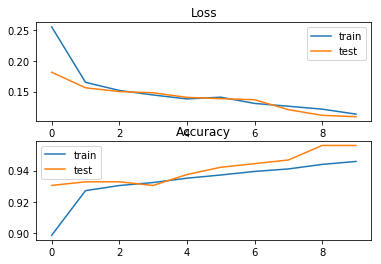

In [292]:
# plot loss during training
from matplotlib import pyplot

pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
pyplot.legend()
pyplot.show()

In [293]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test, verbose=0)

In [294]:
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

In [295]:
from sklearn import metrics

print(metrics.classification_report(yhat_classes, y_test))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92     39123
           1       0.20      0.15      0.17      4111

   micro avg       0.86      0.86      0.86     43234
   macro avg       0.56      0.54      0.55     43234
weighted avg       0.85      0.86      0.85     43234



In [296]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes, average='weighted', labels=np.unique(yhat_classes))
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes, average='weighted', labels=np.unique(yhat_classes))
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes, average='weighted', labels=np.unique(yhat_classes))
print('F1 score: %f' % f1)

Accuracy: 0.862261
Precision: 0.880766
Recall: 0.862261
F1 score: 0.871119


In [297]:
# kappa
kappa = cohen_kappa_score(y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)


Cohens kappa: 0.099771


In [298]:
# ROC AUC
auc = roc_auc_score(y_test, yhat_probs)
print('ROC AUC: %f' % auc)


ROC AUC: 0.601735


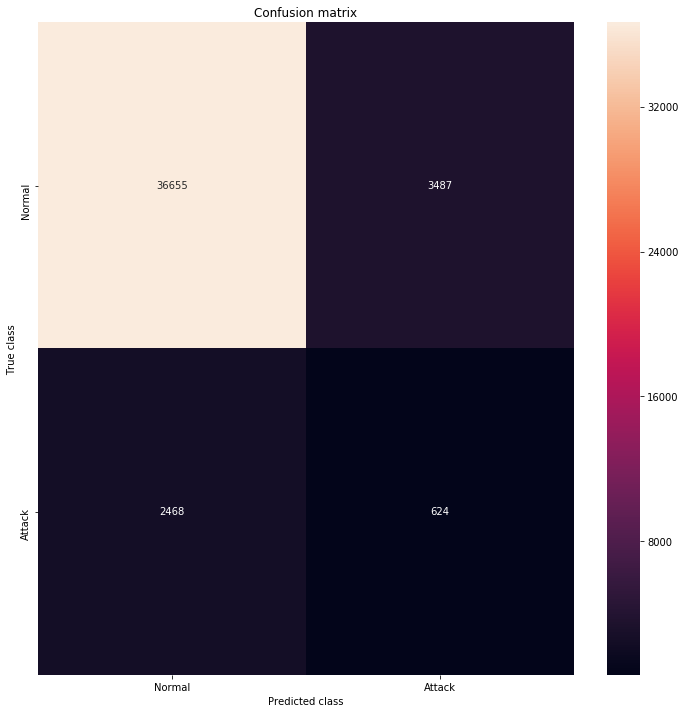

In [299]:
# confusion matrix
import seaborn as sns
LABELS = ["Normal","Attack"]

matrix = confusion_matrix(y_test, yhat_classes)
plt.figure(figsize=(12, 12))
sns.heatmap(matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

## Input/Output Data to LSTM for Sequence Prediction

In [36]:
#https://stackabuse.com/solving-sequence-problems-with-lstm-in-keras/
import numpy
numpy.set_printoptions(threshold=numpy.nan)

def int_to_onehot(n, n_classes):
    v = [0] * n_classes
    v[n] = 1
    return v

def onehot_to_int(v):
    return v.index(1)

X_train, y_train, X_test, y_test
import pprint

pprint.pprint(X_train[:1,:,:])

# systemcall trace-1 length = 819, 
# [6, 6, 63, 6, 42, 120, 6, 195, 120, 6, 6, 114, 114, 1, 1, 252, 252,
# 252, 1, 1, 1, 1, 1, 1, 1, 1, 1, 252, 252, 252, 252, 252, 252, 252, 
# 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 1, 1, 252, 1,
# 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 252, 1, 1, 1, 1, 1, 1, 252,
# 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 1, 1, 1, 1, 1, 1, 
# 1, 1, 1, 1, 252, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
# 1, 252, 1, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252,
# 252, 252, 252, 252, 252, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 252, 252, 1,
# 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 252, 252, 252, 1, 252, 1, 1, 1,
# 1, 252, 1, 1, 1, 1, 1, 1, 1, 1, 1, 252, 252, 252, 252, 252, 1, 1, 1, 1,
# 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
# 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
# 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
# 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
# 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 252, 252, 252, 252, 252, 252,
# 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 1, 1, 1, 1, 1,
# 252, 252, 252, 1, 1, 1, 1, 1, 1, 1, 1, 1, 252, 1, 1, 1, 1, 1, 1, 1, 1, 
# 1, 1, 252, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
# 1, 1, 1, 1, 1, 1, 252, 252, 252, 252, 252, 1, 1, 252, 1, 252, 252, 252, 
# 252, 252, 1, 1, 252, 252, 252, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
# 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
# 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
# 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 252, 1, 1, 1, 1, 1, 
# 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
# 1, 1, 1, 1, 252, 1, 1, 252, 1, 1, 252, 1, 1, 252, 252, 1, 1, 1, 1, 1, 1,
# 1, 1, 1, 252, 1, 1, 1, 1, 1, 1, 252, 252, 252, 1, 1, 1, 1, 1, 1, 1, 1, 
# 1, 1, 1, 1, 1, 1, 1, 1, 252, 1, 1, 1, 1, 1, 252, 1, 1, 1, 1, 1, 1, 1, 
# 252, 1, 1, 1, 1, 1, 1, 252, 252, 1, 1, 1, 1, 1, 252, 252, 252, 252, 1, 
# 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 252, 252, 252, 252, 252, 252, 252, 
# 252, 252, 252, 252, 252, 252, 252, 252, 252, 1, 252, 252, 252, 252, 252,
# 252, 252, 252, 1, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252,
# 252, 252, 252, 252, 252, 1, 252, 252, 1, 252, 252, 1, 1, 252, 252, 252, 
# 1, 1, 252, 252, 252, 252, 1, 1, 1, 1, 1, 1, 1, 1, 252, 252, 252, 252, 
# 252, 252, 252, 1, 252, 252, 252, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
# 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 252, 
# 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 
# 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 1, 252, 252, 1, 
# 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 1,
# 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 252, 1, 1, 1, 1, 252, 252, 252, 252, 
# 252, 252, 252, 1, 252, 1, 1, 252, 1, 1, 252, 1, 252, 252, 252, 252, 252, 
# 252, 252, 252, 252, 252, 1, 252, 1, 1, 252, 1, 252, 252, 252, 1, 252, 
# 252, 252, 1, 1, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 
# 252, 252, 252, 1, 1, 252]


array([[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [40]:
# Sequence [6, 6, 63, 6, 42, 120, 6, 195, 120, 6]
# [X -> 6, 6, 63, 6, 42, 120, 6, 195, 120, Y-> 6]
pprint.pprint(y_train[:1,:])

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [38]:

# Sequence [114 ,162, 114, 114 ,162, 114, 162, 162]
# [X ->114, 162 ,114, 114 ,162, 114, 162  Y-> 162]

test_input = array([[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]]])

test_input = test_input.reshape((1, 19, 341))
test_output = model.predict(test_input, verbose=0)
print(test_output)

NameError: name 'array' is not defined

In [ ]:
# https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352
# https://towardsdatascience.com/lstm-autoencoder-for-extreme-rare-event-classification-in-keras-ce209a224cfb